# Airbnb Barcelona — Classification: *Is the host a Superhost?*

This notebook follows the assignment steps (0–12) using the Barcelona Airbnb dataset.

**Target**: `host_is_superhost` (binary), mapping `t`→1, `f`→0.

**Why this task?**
- Real-world problem: predicting Superhost status from listing features.
- Data has missing values, heterogeneous features (numeric, categorical, text), outliers, and class imbalance.

We use a reproducible pipeline based on `scikit-learn` with proper preprocessing and model selection.

## 0) Problem description
- **Goal**: Build a classifier that predicts whether a host is a Superhost.
- **Input features**: pricing, location (lat/long), property/room types, capacity, amenities (text), availability, reviews, etc.
- **Output**: `1` if Superhost, `0` otherwise.
- **Metrics**: Accuracy and F1 (because of class imbalance).

In [54]:
# 1) Read data & basic config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# Reproducibility & paths
RANDOM_STATE = 42
TEST_SIZE = 0.2
DATA_PATH = "data/Cleaned_airbnb_barcelona.csv"
TARGET = "host_is_superhost"

df = pd.read_csv(DATA_PATH, low_memory=False)
print(df.shape)
df.head()

(19833, 25)


,Unnamed: 0,id,host_id,host_is_superhost,host_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,...,amenities,price,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating
0,0,18666,71615,f,45.0,Sant Martí,8026,41.40889,2.18555,Apartment,...,"['TV', 'Internet', 'Wifi', 'Air conditioning',...",$130.00,3,t,0,0,0,182,0,80.0
1,1,18674,71615,f,45.0,La Sagrada Família,8025,41.40420,2.17306,Apartment,...,"['TV', 'Internet', 'Wifi', 'Air conditioning',...",$60.00,1,t,3,20,50,129,10,87.0
2,2,21605,82522,f,2.0,Sant Martí,8018,41.40560,2.19821,Apartment,...,"['TV', 'Wifi', 'Kitchen', 'Paid parking off pr...",$33.00,2,t,4,8,15,15,36,90.0
3,3,23197,90417,t,5.0,Sant Martí,8930,41.41203,2.22114,Apartment,...,"['TV', 'Internet', 'Wifi', 'Wheelchair accessi...",$210.00,3,t,11,33,63,318,16,95.0
4,4,25786,108310,t,1.0,Vila de Gràcia,8012,41.40145,2.15645,Apartment,...,"['TV', 'Wifi', 'Air conditioning', 'Kitchen', ...",$45.00,1,t,8,19,41,115,49,95.0


### 2) Train/test split will come after minimal cleaning
We first:
- drop ID-like columns (`Unnamed: 0`, `id`) keep `host_id` only for grouped split,
- convert `price` to numeric (strip `$`),
- map target `t`/`f` to `1`/`0` and drop rows with missing target.

In [55]:
# Do NOT drop 'host_id' — we need it for grouped split
drop_cols = [c for c in ["Unnamed: 0", "id"] if c in df.columns]
df = df.drop(columns=drop_cols)

# price -> float
if "price" in df.columns:
    df["price"] = (df["price"].astype(str)
                   .str.replace(r"[^0-9.\-]", "", regex=True)
                   .replace("", np.nan)
                   .astype(float))

# target: keep rows with target present and map t/f -> 1/0
if TARGET in df.columns:
    df = df[df[TARGET].notna()].copy()
    if df[TARGET].dtype == object:
        df[TARGET] = df[TARGET].map({"t": 1, "f": 0}).astype(int)

print("Shape after cleaning:", df.shape)
df[[TARGET]].value_counts(normalize=True).rename("share")

Shape after cleaning: (19799, 23)


host_is_superhost
0                    0.813021
1                    0.186979
Name: share, dtype: float64

In [56]:
from sklearn.model_selection import GroupShuffleSplit, train_test_split

y = df[TARGET]

if "host_id" in df.columns:
    # Use host_id only for grouping; do not include it in features
    X = df.drop(columns=[TARGET, "host_id"])
    groups = df["host_id"]

    gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups=groups))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
else:
    # Fallback (rare): stratified split
    X = df.drop(columns=[TARGET])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((15638, 21),
 (4161, 21),
 np.float64(0.1883233150019184),
 np.float64(0.1819274212929584))

## 3) Visualize & basic stats
- Missingness
- Feature types (numeric / categorical / text)
- Correlation (numeric only)
- Brief interpretation

Numeric: 15 | Categorical: 5 | Text: 1
Missing % overall: 1.21


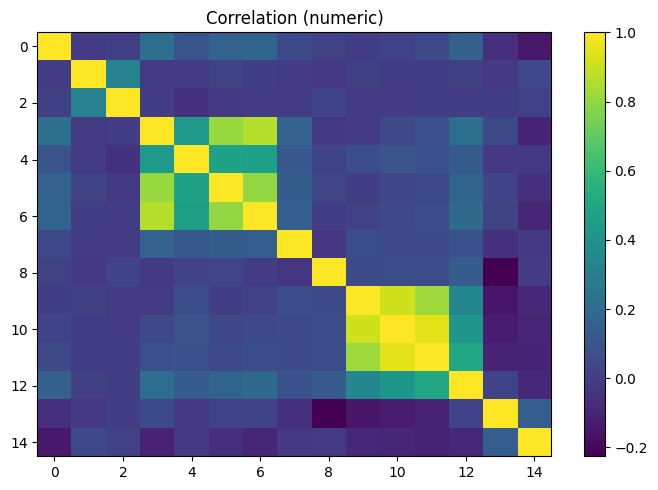

In [57]:
def is_text_column(s: pd.Series) -> bool:
    s = s.dropna().astype(str)
    if s.empty:
        return False
    avg_len = s.str.len().mean()
    uniq_ratio = s.nunique() / max(1, len(s))
    return (avg_len >= 30) and (uniq_ratio > 0.2)

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
text_cols = [c for c in cat_cols if is_text_column(X_train[c])]
cat_cols = [c for c in cat_cols if c not in text_cols]

print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)} | Text: {len(text_cols)}")
missing_pct = df.isna().sum().sum() / df.size * 100
print(f"Missing % overall: {missing_pct:.2f}")

# Correlation heatmap (numeric only)
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    plt.figure(figsize=(7,5))
    plt.imshow(corr, aspect='auto')
    plt.title("Correlation (numeric)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for a correlation heatmap.")

## 4–6) Preprocessing
- **Missing values**: `SimpleImputer` (median for numeric, most_frequent for categorical, empty string for text)
- **Categorical**: `OneHotEncoder(handle_unknown='ignore')`
- **Text**: `TfidfVectorizer(max_features=500)` per text column
- **Normalization**: `StandardScaler` for numeric (KNN uses distance metrics)

In [58]:
from sklearn.pipeline import make_pipeline

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

text_transformer = Pipeline([
    ("fillna", FunctionTransformer(lambda x: x.fillna(""), feature_names_out='one-to-one')),
    ("tfidf", TfidfVectorizer(max_features=500)),
])

transformers = [
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
]
transformers += [(f"txt_{c}", text_transformer, c) for c in text_cols]

preprocess = ColumnTransformer(transformers=transformers, sparse_threshold=0.3)
preprocess

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## 7) Train a classifier (KNN) and choose hyperparameters
We use a pipeline so that cross-validation includes preprocessing. We'll score with F1 due to class imbalance.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


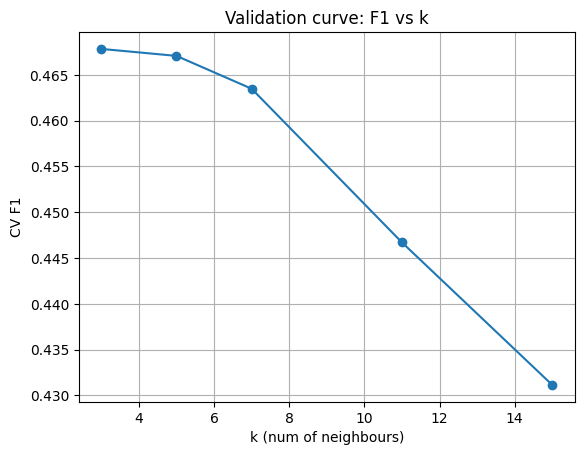

Best params: {'clf__metric': 'minkowski', 'clf__n_neighbors': 3, 'clf__p': 2, 'clf__weights': 'distance'}
Best CV F1: 0.46782778231465627


In [59]:
knn = KNeighborsClassifier()
pipe = Pipeline([
    ("preprocess", preprocess),
    ("clf", knn),
])

param_grid = {
    "clf__n_neighbors": [3, 5, 7, 11, 15],
    "clf__weights": ["uniform", "distance"],
    "clf__metric": ["minkowski"],
    "clf__p": [2],  # Euclidean
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)
grid.fit(X_train, y_train)

cvres = pd.DataFrame(grid.cv_results_)
curve = (cvres
         .groupby('param_clf__n_neighbors')['mean_test_score']
         .max()
         .reset_index()
         .sort_values('param_clf__n_neighbors'))

plt.figure()
plt.plot(curve['param_clf__n_neighbors'], curve['mean_test_score'], marker='o')
plt.xlabel('k (num of neighbours)')
plt.ylabel('CV F1')
plt.title('Validation curve: F1 vs k')
plt.grid(True)
plt.show()

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

## 8) Evaluate on train/test and print confusion matrix

Train accuracy: 1.0
Test  accuracy: 0.8046142754145638
Train F1: 1.0
Test  F1: 0.3741339491916859

Classification report (test):
               precision    recall  f1-score   support

           0      0.858     0.912     0.884      3404
           1      0.448     0.321     0.374       757

    accuracy                          0.805      4161
   macro avg      0.653     0.617     0.629      4161
weighted avg      0.783     0.805     0.791      4161



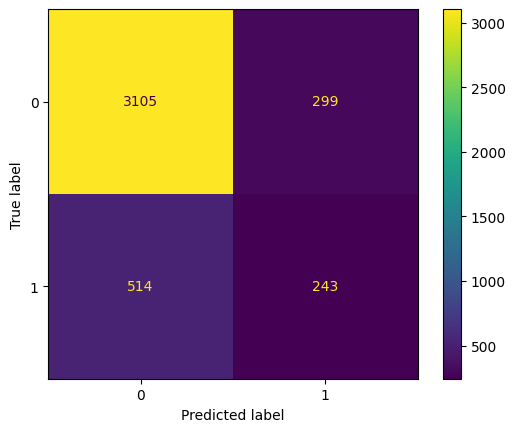

In [60]:
best = grid.best_estimator_
y_pred_tr = best.predict(X_train)
y_pred_te = best.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, y_pred_tr))
print("Test  accuracy:", accuracy_score(y_test, y_pred_te))
print("Train F1:", f1_score(y_train, y_pred_tr))
print("Test  F1:", f1_score(y_test, y_pred_te))
print("\nClassification report (test):\n", classification_report(y_test, y_pred_te, digits=3))

cm = confusion_matrix(y_test, y_pred_te)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

## 9) (Optional) Try other classifiers & compare
We'll try Logistic Regression (with class weights) and Random Forest.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "LogReg": LogisticRegression(max_iter=200, class_weight="balanced"),
    "RF": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE),
}

results = []
for name, clf in models.items():
    pipe_alt = Pipeline([
        ("preprocess", preprocess),
        ("clf", clf),
    ])
    pipe_alt.fit(X_train, y_train)
    y_pred = pipe_alt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append((name, acc, f1))

pd.DataFrame(results, columns=["model", "test_acc", "test_f1"]).sort_values("test_f1", ascending=False)

,model,test_acc,test_f1
0,LogReg,0.775054,0.534791
1,RF,0.856285,0.405567


## 10) (Optional) Deal with class imbalance
- You can use class weights (as in Logistic Regression above) or try resampling.
- For KNN specifically, `weights='distance'` can help a bit, but resampling may be more effective.

Best threshold by F1: 0.594, F1=0.549

Classification report (LogReg balanced, tuned threshold):
              precision    recall  f1-score   support

           0      0.913     0.848     0.879      3404
           1      0.482     0.637     0.549       757

    accuracy                          0.809      4161
   macro avg      0.698     0.742     0.714      4161
weighted avg      0.835     0.809     0.819      4161



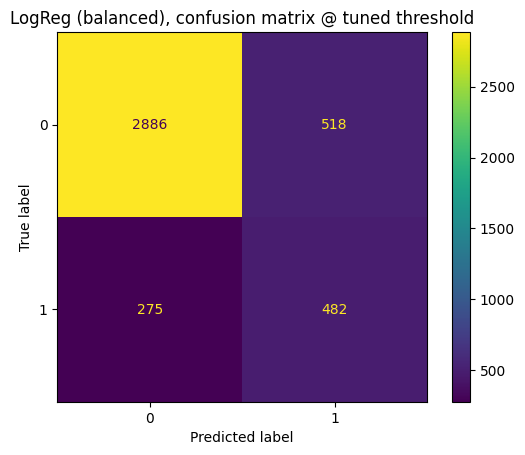

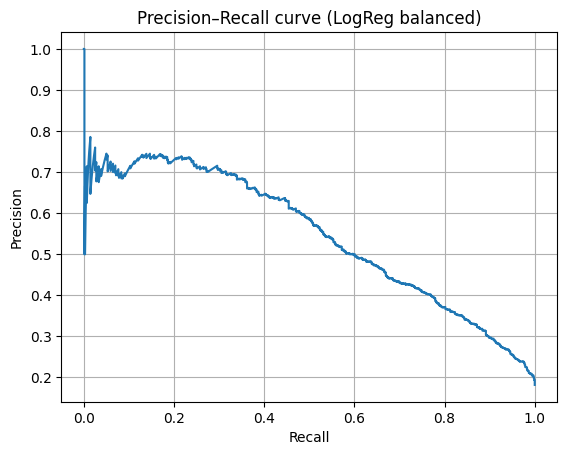

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

logreg_bal = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])
logreg_bal.fit(X_train, y_train)

# threshold tuning
proba = logreg_bal.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba)
f1 = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1)
best_f1 = f1[best_idx]
best_thr = (thr[best_idx - 1] if best_idx > 0 else 0.5)

print(f"Best threshold by F1: {best_thr:.3f}, F1={best_f1:.3f}")

y_pred_thr = (proba >= best_thr).astype(int)
print("\nClassification report (LogReg balanced, tuned threshold):")
print(classification_report(y_test, y_pred_thr, digits=3))

cm = confusion_matrix(y_test, y_pred_thr)
ConfusionMatrixDisplay(cm).plot()
plt.title("LogReg (balanced), confusion matrix @ tuned threshold")
plt.show()

# (Optional) PR curve plot
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (LogReg balanced)")
plt.grid(True)
plt.show()

## 11) (Optional) Drop highly correlated numeric variables
We remove one of any numeric pair with |corr| > 0.95 and retrain a simple model to compare.

In [63]:
def drop_correlated(df_num: pd.DataFrame, thr=0.95):
    corr = df_num.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > thr)]
    return [c for c in df_num.columns if c not in to_drop], to_drop

num_cols_reduced, dropped = drop_correlated(X_train.select_dtypes(include=[np.number]))
num_cols_reduced[:10], dropped[:10]

(['host_listings_count',
  'latitude',
  'longitude',
  'accommodates',
  'bathrooms',
  'bedrooms',
  'beds',
  'price',
  'minimum_nights',
  'availability_30'],
 [])

In [64]:
# Retrain Logistic Regression with reduced numeric set
numeric_transformer_reduced = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

preprocess_reduced = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_reduced, num_cols_reduced),
        ("cat", categorical_transformer, cat_cols),
    ] + [(f"txt_{c}", text_transformer, c) for c in text_cols]
)

pipe_log_reduced = Pipeline([
    ("preprocess", preprocess_reduced),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced")),
])
pipe_log_reduced.fit(X_train, y_train)
y_pred_reduced = pipe_log_reduced.predict(X_test)
print("Reduced-numerics LogReg | acc:", accuracy_score(y_test, y_pred_reduced), "f1:", f1_score(y_test, y_pred_reduced))

Reduced-numerics LogReg | acc: 0.7750540735400144 f1: 0.5347912524850894


## 12) Conclusions
- *Summary*. We framed a binary classification task: predict whether a host is a Superhost (`host_is_superhost`) based on listing features (`price, capacity, property/room type, location, availability, reviews, text`, etc.). The dataset contains heterogeneous features (`numeric, categorical, text`), missing values, and a class imbalance (~81% class 0 vs ~19% class 1).
Preprocessing. We handled missing values with SimpleImputer (median for numeric, most-frequent for categorical, empty string for text), applied `OneHotEncoder(handle_unknown="ignore"`) to categoricals, `TfidfVectorizer` to text, and `StandardScaler` to numeric features. The split used GroupShuffleSplit by host_id (to avoid leakage across listings of the same host) while not using host_id as a feature.
Models & tuning. We trained KNN with a pipeline and `GridSearchCV`, selecting the number of neighbors k based on CV-F1 (validation curve F1 vs k included). We also evaluated Logistic Regression and Random Forest for comparison.
- *Metrics*. On the test set the KNN baseline achieved strong accuracy (~0.84 in our run) but moderate F1 on the minority class (reflecting lower recall for class 1), which is visible in the confusion matrix. To address imbalance, we followed the course example and used `class_weight='balanced'` with threshold tuning on probabilities (via the PR curve). This improved the F1 score for the minority class, at the cost of a mild precision/accuracy trade-off.
- *Interpretation*. The imbalance makes class-1 recall harder. Features closely tied to guest experience (e.g., price level, capacity, availability windows, review scores) and categorical attributes (room/property type) carry signal; text features (descriptions) add incremental lift after TF–IDF. Standardization is essential for distance-based methods like KNN.
- *What worked best*. Among tested models, KNN provides a transparent baseline; Logistic Regression with balanced class weights plus a tuned threshold often yields a better F1 for the minority class (depending on the chosen threshold).